# Generative Adversarial Network for cat drawings

In [ ]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [3]:
try:
    cats = np.load("./cats.npy")

    Y = []
    for i in range(cats.shape[0]):
        Y.append([1,0])
    Y = np.array(Y)

    (x_train, y_train, x_test, y_test) = train_test_split(cats, Y)
    x_train = (x_train.astype(np.float32)) / 255
    x_train = x_train.reshape(x_train.shape[0], 28, 28)
    
except Exception as e:
    print (e)   

In [17]:
x_train.shape

(92401, 28, 28)

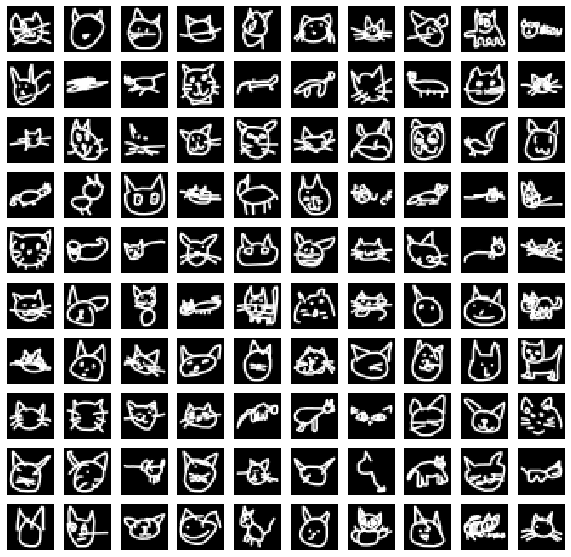

In [16]:
# some images from the dataset
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

In [5]:
lr = 0.0002
beta = 0.5
random_input_dim = 100

In [6]:
G = Sequential()
G.add(Input(shape=(random_input_dim,)))
G.add(Dense(7*7*256, use_bias=False))
G.add(BatchNormalization())
G.add(LeakyReLU())
G.add(Reshape((7, 7, 256)))
G.add(Conv2DTranspose(128, (5, 5), padding='same', use_bias=False))
G.add(BatchNormalization())
G.add(LeakyReLU())
G.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
G.add(BatchNormalization())
G.add(LeakyReLU())
G.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

G.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr, beta_1=beta))
generator = G
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [7]:
D = Sequential()
D.add(Input(shape=(28, 28, 1)))
D.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
D.add(LeakyReLU())
D.add(Dropout(0.3))
D.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
D.add(LeakyReLU())
D.add(Dropout(0.3))
D.add(Flatten())
D.add(Dense(1, activation='sigmoid'))

D.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr, beta_1=beta))
discriminator = D
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [8]:
discriminator.trainable = False
catgan_input = Input(shape=[random_input_dim,])
x = generator(catgan_input)
catgan_output = discriminator(x)
catgan = Model(inputs=catgan_input, outputs=catgan_output)
catgan.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr, beta_1=beta))
catgan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         2330944   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 2,543,809
Trainable params: 2,305,472
Non-trainable params: 238,337
_________________________________________________________________


In [9]:
def save_generated_images(epoch, generator, show_images=False):
    num_examples = 100
    random_noise = np.random.normal(0, 1, size=[num_examples, random_input_dim])
    generated_images = generator.predict(random_noise)
    generated_images = generated_images.reshape(num_examples, 28, 28)

    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_images[i], cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'generated_image_epoch_{epoch}.png')
    if show_images:
        plt.show()

In [ ]:
num_epochs = 200
batch_size = 256
batch_count = int(x_train.shape[0] // batch_size)

for epoch in range(1, num_epochs + 1):
    for i in tqdm(range(batch_count), desc=f"Epoch {epoch}"):

        random_noise = np.random.normal(0, 1, size=[batch_size, random_input_dim])
        # take random batch of pictures from the training set
        image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        image_batch = np.expand_dims(image_batch, 3)

        generated_images = generator.predict(random_noise)
        X_discriminator = np.concatenate([image_batch, generated_images])

        y_discriminator = np.ones(batch_size*2)
        y_discriminator[batch_size:] = 0

        discriminator.trainable = True
        discriminator.train_on_batch(X_discriminator, y_discriminator)

        random_noise = np.random.normal(0, 1, size=[batch_size, random_input_dim])
        y_generator = np.ones(batch_size)
        discriminator.trainable = False
        catgan.train_on_batch(random_noise, y_generator)

    if epoch == 1 or epoch % 20 == 0:
        save_generated_images(epoch, generator)        


In [ ]:
a = generator.predict(np.random.normal(0, 1, size=[256, random_input_dim]))

In [ ]:
a = a.reshape(256, 28, 28)

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(a[i])

In [ ]:
a = np.random.normal(0, 1, size=[batch_size, random_input_dim])
img = generator.predict(a)
img.shape

In [ ]:
c = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
c = np.expand_dims(c, 3)
c.shape